In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [20]:
train = pd.read_parquet('train.parquet')
train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


# Проверка на пропуски в данных

In [21]:
train.isnull().sum()

,0
id,0
dates,0
values,0
label,0


# Пример визуализации одного ряда

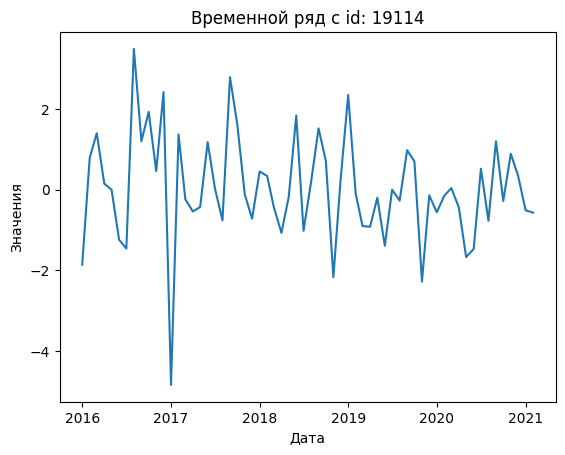

In [22]:
example_series = train.iloc[0]

plt.plot(example_series['dates'], example_series['values'])
plt.title(f"Временной ряд с id: {example_series['id']}")
plt.xlabel('Дата')
plt.ylabel('Значения')
plt.show()


# Визуализация временных рядов для каждого класса

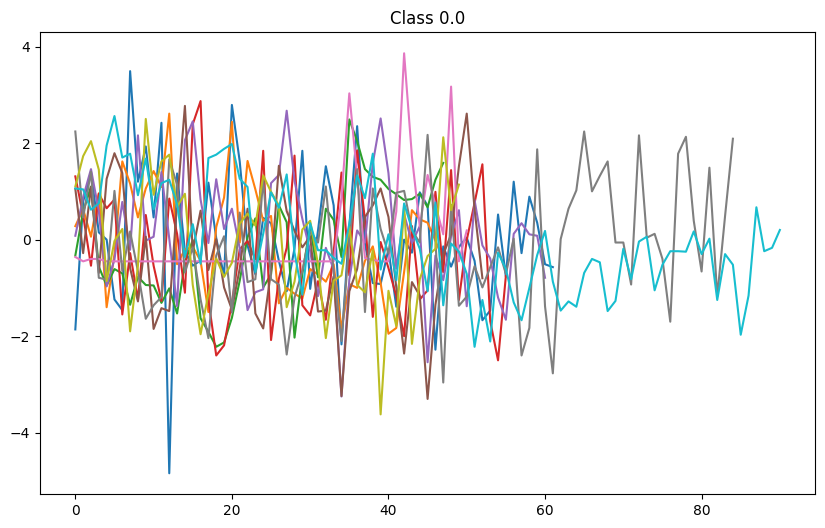

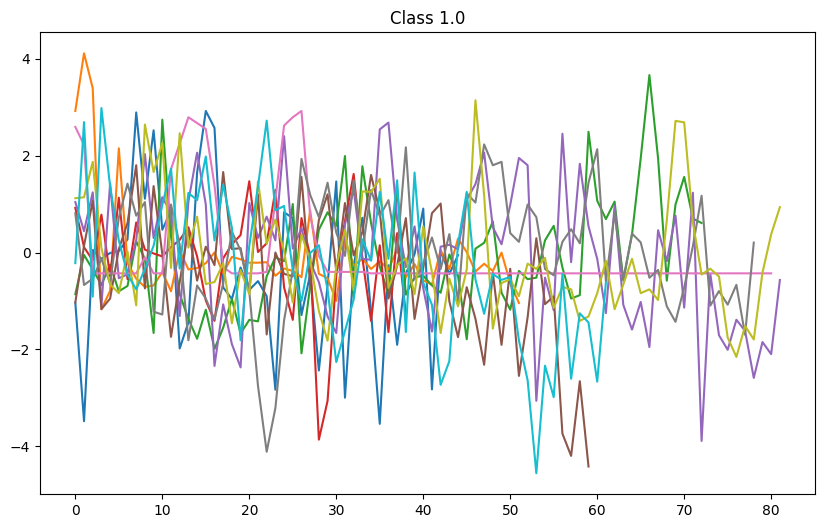

In [23]:
for label in train['label'].unique():
    subset = train[train['label'] == label]
    plt.figure(figsize=(10, 6))
    for values in subset['values'].head(10):
        plt.plot(values)
    plt.title(f"Class {label}")
    plt.show()

# Как видно из графиков, в рядах отсутствует какой-либо тренд или сезонность. Поэтому все возможные гипотезы сразу отпали. Также видно что для рядов 1 класса больше значений.

label
0.0    57820
1.0    22180
Name: count, dtype: int64


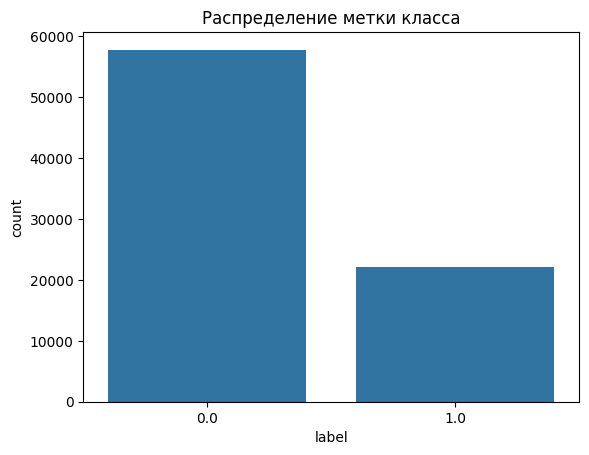

In [24]:
sns.countplot(x='label', data=train)
plt.title('Распределение метки класса')
print(train['label'].value_counts())
plt.show()

Cоздам признаки на основе временных рядов по которым и буду обучать модель

In [25]:
def calculate_autocorrelation(values):
    return acf(values, nlags=10)


def count_direction_changes(values):
    return np.sum(np.diff(np.sign(np.diff(values))) != 0)

def generate_features(df):
    features = pd.DataFrame()
    features['mean'] = df['values'].apply(np.mean)
    features['std'] = df['values'].apply(np.std)
    features['median'] = df['values'].apply(np.median)
    features['min'] = df['values'].apply(np.min)
    features['max'] = df['values'].apply(np.max)
    features['range'] = features['max'] - features['min']
    features['len_series'] = df['values'].apply(len)
    features['autocorrelation'] = df['values'].apply(lambda x: calculate_autocorrelation(x)[1])
    features['direction_changes'] = df['values'].apply(count_direction_changes)
    return features

train_features = generate_features(train)
train_features.head()

,mean,std,median,min,max,range,len_series,autocorrelation,direction_changes
0,0.023710,1.337272,-0.110000,-4.840000,3.49,8.330000,62,-0.111439,37
1,-0.310777,1.556337,-0.274409,-3.534409,2.92,6.454409,45,0.189286,29
2,-0.046042,1.065023,-0.145000,-1.950000,2.61,4.560000,48,0.500204,29
3,-0.130000,1.158201,-0.345000,-2.220000,2.49,4.710000,48,0.688139,22
4,-0.270536,1.270529,-0.475000,-2.500000,2.87,5.370000,56,0.087387,35


Обучение модели

In [26]:
y = train['label']
X_train, X_test, y_train, y_test = train_test_split(train_features, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=2)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
roc_score_rf = roc_auc_score(y_test, y_pred)
print(f"Best ROC_score: {roc_score_rf}")

Best ROC_score: 0.8499755077270635


In [27]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)